# 2017 W09 Individual Assignment Acceleration and Uncertainty

In the lab we measured one component of acceleration and integrated it to get velocity and position. The results for velocity and especially position quickly drifted away from correct values, accumulating more and more error as the integration progressed. To better understand this process we will simulate it.

Start by importing all the usual stuff.

In [1]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(14, 7)

## Calculation Functions

We may still need these functions to calculate smoothed and averaged versions of our data, and to take derivatives of our time series data, both raw and smoothed. 

In [2]:
def movingAverage(T,backward = 0,forward = 0):
    # return a moving averaged version of T that includes 
    # up to backward samples from before the current point
    # and up to forward samples from after the current point
    # Tails of the sample will be averaged using fewer points.
    Tma = T.copy()                   # a copy to store the averaged values in
    for i in range(0,len(T)): 
        s = max(i-backward,0)        # start at 0 or backward
        f = min(i+forward+1,len(T))  # finish at forward or end of data
        Tma[i] = np.mean(T[s:f])
    return Tma

def expSmooth(t,T,tau):        # returns a smoothed version of T with time constant tau
    Ts = T.copy()              # another vector for the smoothed data
    for i in range(1,len(Ts)): # here's where the actual smoothing happens
        dt = t[i]-t[i-1]
        w = min(dt/tau,1)
        Ts[i] = Ts[i-1] * (1-w) + T[i] * w
    return Ts                  # return the smoothed data

    
def dvdtDiff(t,v,steps = 1):    # First derivative of data by delta v / delta t
    dv = zeros(len(t))          # Look back by steps time steps in the samples
    for i in range(0,len(t)):
        if(i<steps): j = steps  # start gracefully - estimate as first calculable
        else: j = i
        dv[i] = (v[j]-v[j-steps])/(t[j]-t[j-steps])
    return dv

## Simulate the real position, velocity and acceleration

We know from last week that we can differentiate position to get velocity and acceleration, all as a function of time. To test our calculations, we need some approximation of reality without noise and other errors in the data.

`P, V, and A` will provide us with a ground truth for consistent position, velocity and acceleration data. A sinusoid within a Gaussian envelope provides a position that is similar to the motions we applied to the accelerometer.

Defining a function called `IntPlot` will let us repeat the same plot for different conditions and comparisons.


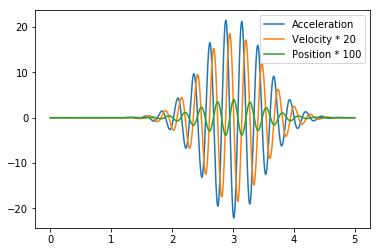

In [3]:
# These values, P, V, A will represent our simulated reality
n = 10000   # make some simulated position data, symmetric and centred around 0
t = linspace(0,5,n)
P = 0.1 * norm.pdf((t-3)*2)*sin(23.467*t)  # wave in a Gaussian envelope
V = dvdtDiff(t,P)      # differentiate to get velocity and acceleration
A = dvdtDiff(t,V)

def IntPlot(t,P,V,A):      # Plot out some results
    plot(t,A,label="Acceleration")
    plot(t,V*20,label="Velocity * 20")
    plot(t,P*100,label="Position * 100")
    legend()

IntPlot(t,P,V,A)

## Q1 Create and Test the Integration Function

Create a new function called `Integrate()` to do an integration over time, following the same calculation approach we used in the lab.

Start with the acceleration data and integrate to recover the position and velocity data. Defining a function `IntAcc()` will let us repeat the process under different conditions.

In [4]:
def Integrate(t,x):                 # Integral over time by trapezoidal rule
    I = zeros(len(t))               # The integral is 0 at time 0
    for i in range(1,len(t)):       # Add an incremental amount to the integral for each time step
        # Add your own code here to calculate each step in the integration
        avg = (x[i]+x[i-1])/2.0     # average value of x during the time step
        inc = avg * (t[i]-t[i-1])   # times delta t to give next integration step
        I[i] = I[i-1] + inc         # add to previous integration steps
    return I

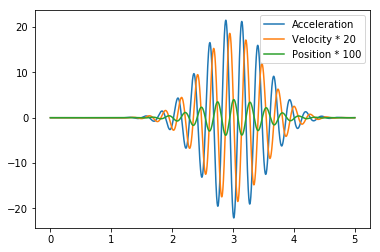

In [5]:
def IntAcc(t,A):            # start with the acceleration and integrate to get V and P
    V = Integrate(t,A)      # results should be the same
    P = Integrate(t,V)
    return (P,V,A)

P1,V1,A1 = IntAcc(t,A)
IntPlot(t,P1,V1,A1)

## Q2 Import your lab data and do the base case calculations

Import your lab data for acceleration as a function of time and assign those values to the arrays `traw` and `Araw`. Integrate to get velocity and position and plot the results. How do they compare to the results you got from the integration performed in the Arduino sketch?

[['\ufeffTime [us]' ' A0' ' A1']
 ['3001488' '267' '398']
 ['3004104' '265' '392']
 ['3006736' '266' '393']
 ['3009400' '266' '400']]


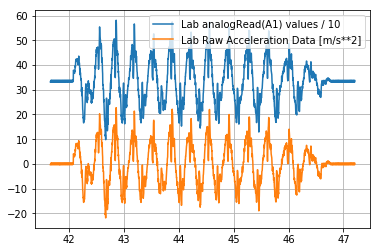

In [7]:
# My collected data is just analog acceleration data, taken very quickly
with open('W09 Raw Data.csv') as csvfile:    # This is my raw data, you should use yours
    dataRead = csv.reader(csvfile)
    a = np.asarray([data for data in dataRead])
print(a[:5])
# chop out just the interesting part
traw = asfarray(a[14000:16000,0])/1000000.  # put the time in seconds
AnIn = asfarray(a[14000:16000,2])           # this is my analogRead(A1) data
# This is my calibration relationship, you should use your own
Araw = 0.0923* (AnIn - 334.5)
plot(traw,AnIn/10, label='Lab analogRead(A1) values / 10')
plot(traw,Araw, label= 'Lab Raw Acceleration Data [m/s**2]')
legend()
grid()


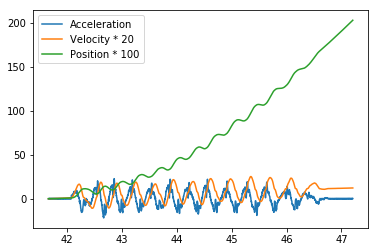

In [8]:
P1,V1,A1 = IntAcc(traw,Araw)
IntPlot(traw,P1,V1,A1)

These results are similar to the results from the lab. This gives me confidence that the two calculations are following the same approach and that the drift is a problem arising from the actual measurements.

## Acceleration data will have both bias and noise uncertainty

Every time we set up to measure we will have an unknown bias resulting from our calibration and measurement configuration. It will vary at random for every setup, but remain the same for the duration of the measurement. This is like the offset errors we had in measuring temperature with the TMP36.

Every individual measurement will have some random noise that averages out to zero over time. WIll the effects of that noise integrate to zero over time as well.

`Anoise` adds a large array of individual random noise values to the base case acceleration. `Abias` adds the same random value to all of the elements in the base case acceleration.

Large values for both are used below to emphasize the differences, but both should be fairly small if you wired your circuits carefully and did your calibrations correctly.


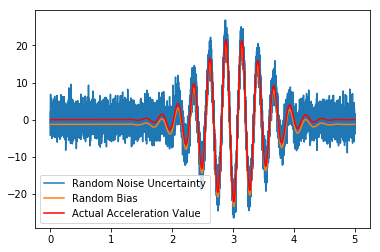

In [9]:
Anoise = A + random.randn(len(A))*2.5
Abias = A + random.randn() * 2
plot(t,Anoise,label='Random Noise Uncertainty')
plot(t,Abias,label='Random Bias')
plot(t,A,label='Actual Acceleration Value',color = 'red')
legend()

We can run the calculations for the noisy data and see some moderate drift, even with a really high noise level. We know what the actual P value should be, without noise, so we can calculate the error in our integrated value as a function of time.

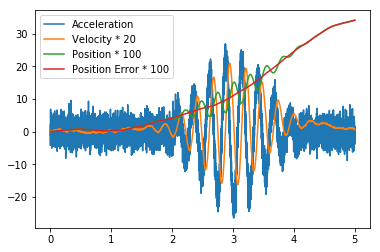

In [10]:
P1,V1,A1 = IntAcc(t,Anoise)
IntPlot(t,P1,V1,A1)
plot(t,(P1-P)*100,label='Position Error * 100')
legend()

## Q3 Repeat the calculation for a consistent bias

Generate a new set of `Abias` values with a random bias uncertainty of +/- 0.1 $m/s^2$, run the `IntAcc()` and error calculations and plot the results. Try it multiple times and comment on the resulting position error.

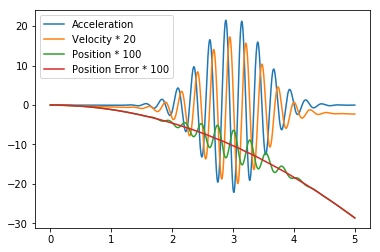

In [11]:
Abias = A + random.randn() * 0.1/2   # standard deviation = uncertainty / 2
P1,V1,A1 = IntAcc(t,Abias)
IntPlot(t,P1,V1,A1)
plot(t,(P1-P)*100,label='Position Error * 100')
legend()

The position error always grows with time, either positive or negative, depending on the sign of the bias. The random bias means that the magnitude of the error is different in every simulation. A bias in the measurement has a much larger cumulative effect than noise of the same magnitude.

## Q4 Random Combinations of Bias and Noise

Simulate an acceleration of A plus a combination of a random bias uncertainty of 0.01 $m/s^2$ and noise uncertainty in individual measurements of 0.25 $m/s^2$ and calculate the resulting position error as a function of time. Repeat the calculation 20 times and plot all 100 error curves to visualize the distribution of possible results. My calculations show a spread of about 10 to 15 cm by 5 seconds out, with variations depending on the random selections.

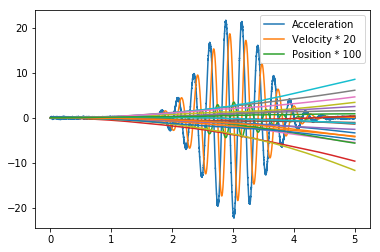

In [12]:
for i in range(0,20):
    Acombo = A + random.randn()*0.01/2 + random.randn(len(A))*0.25/2
    P1,V1,A1 = IntAcc(t,Acombo)
    if i == 0: IntPlot(t,P1,V1,A1)
    plot(t,(P1-P)*100,label='Position Error * 100')

I don't know how I would estimate position uncertainty analytically, but we can do it with a Monte Carlo simulation. Run the position error calculation above 100 times and plot a histogram of those position errors. Compare the histogram to a Gaussian distribution with the same mean and standard deviation. Try 1000 times instead and comment on any differences. What is the uncertainty in position after 5 seconds?

0.0022032730410207367 0.05950315422010033


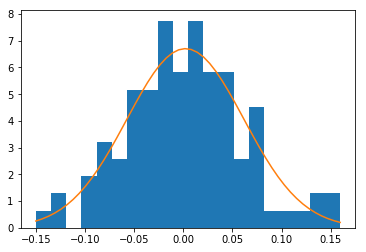

In [14]:
def Monte(t,A,bias,noise,c = 100):
    u = zeros(c)
    for i in range(0,c):
        Acombo = A + random.randn()*0.01/2 + random.randn(len(A))*0.25/2
        P1,V1,A1 = IntAcc(t,Acombo)
        u[i] = P1[len(P1)-1]-P[len(P)-1]
    hist(u,bins=20,density=True)
    x = linspace(min(u),max(u))
    plot(x,norm.pdf(x,mean(u),std(u)))
    print(mean(u),std(u))
   
Monte(t,A,0.01,0.1,100)

Both the 100 and 1000 times simulations yield standard deviations of about 0.065 metres, for an uncertainty of 13 cm, around the middle of the range we can estimate from the original graph.

Does the magnitude of the uncertainty depend on the actual acceleration? Test by repeating the calculation for `A=zeros(len(t))` and comment.

0.00013126300256610505 0.06551091257120538


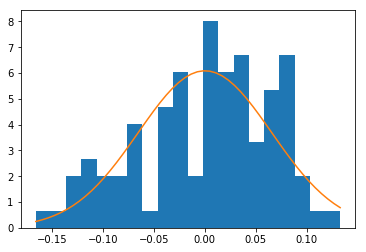

In [15]:
Monte(t,zeros(len(t)),0.01,0.1,100)

It looks like the distribution is narrower when the underlying acceleration is zero. The magnitude of the accelerations seems to have an amplifying effect on the ultimate position error. We would need more analysis to find out the details. 